# Convolutional Neural Network for traffic Sign Recognition

### Import required packages

In [1]:
import pickle
import numpy as np
import cv2
import csv
import random
from sklearn.model_selection import train_test_split
from sklearn .utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# Visualizations will be shown in the notebook.
%matplotlib inline
from keras.datasets import cifar10

Using TensorFlow backend.


## Load The Data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    labelNameDict = {rows[0]:rows[1] for rows in reader}

In [3]:
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 2D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES


In [4]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train.shape[1:]
uniq_classes, uniq_indexes, uniq_class_counts=np.unique(y_train, return_index=True, return_counts=True)
n_classes = len(uniq_classes)
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Utility Funcitons

Also plot the sample images

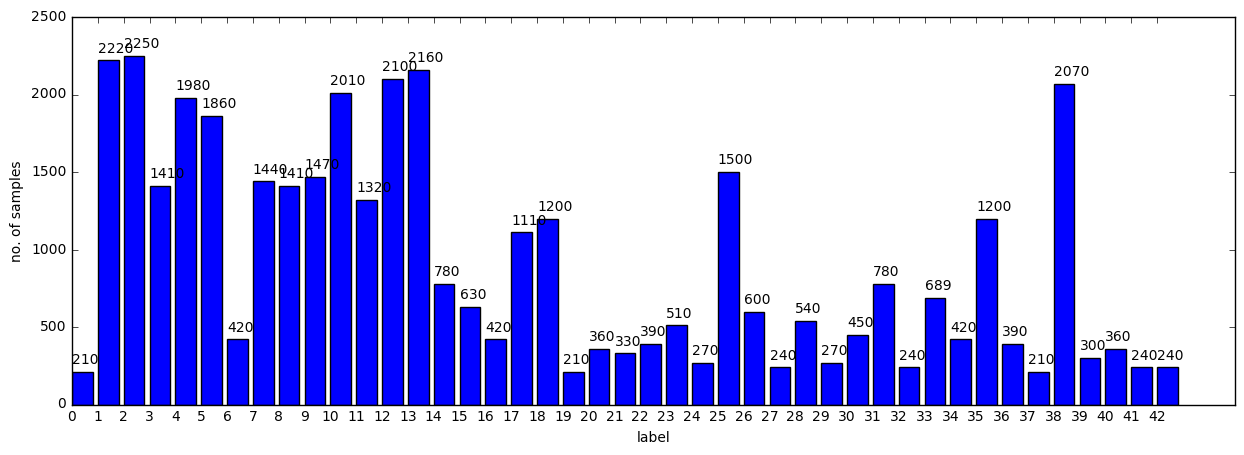

Sample Image for each label


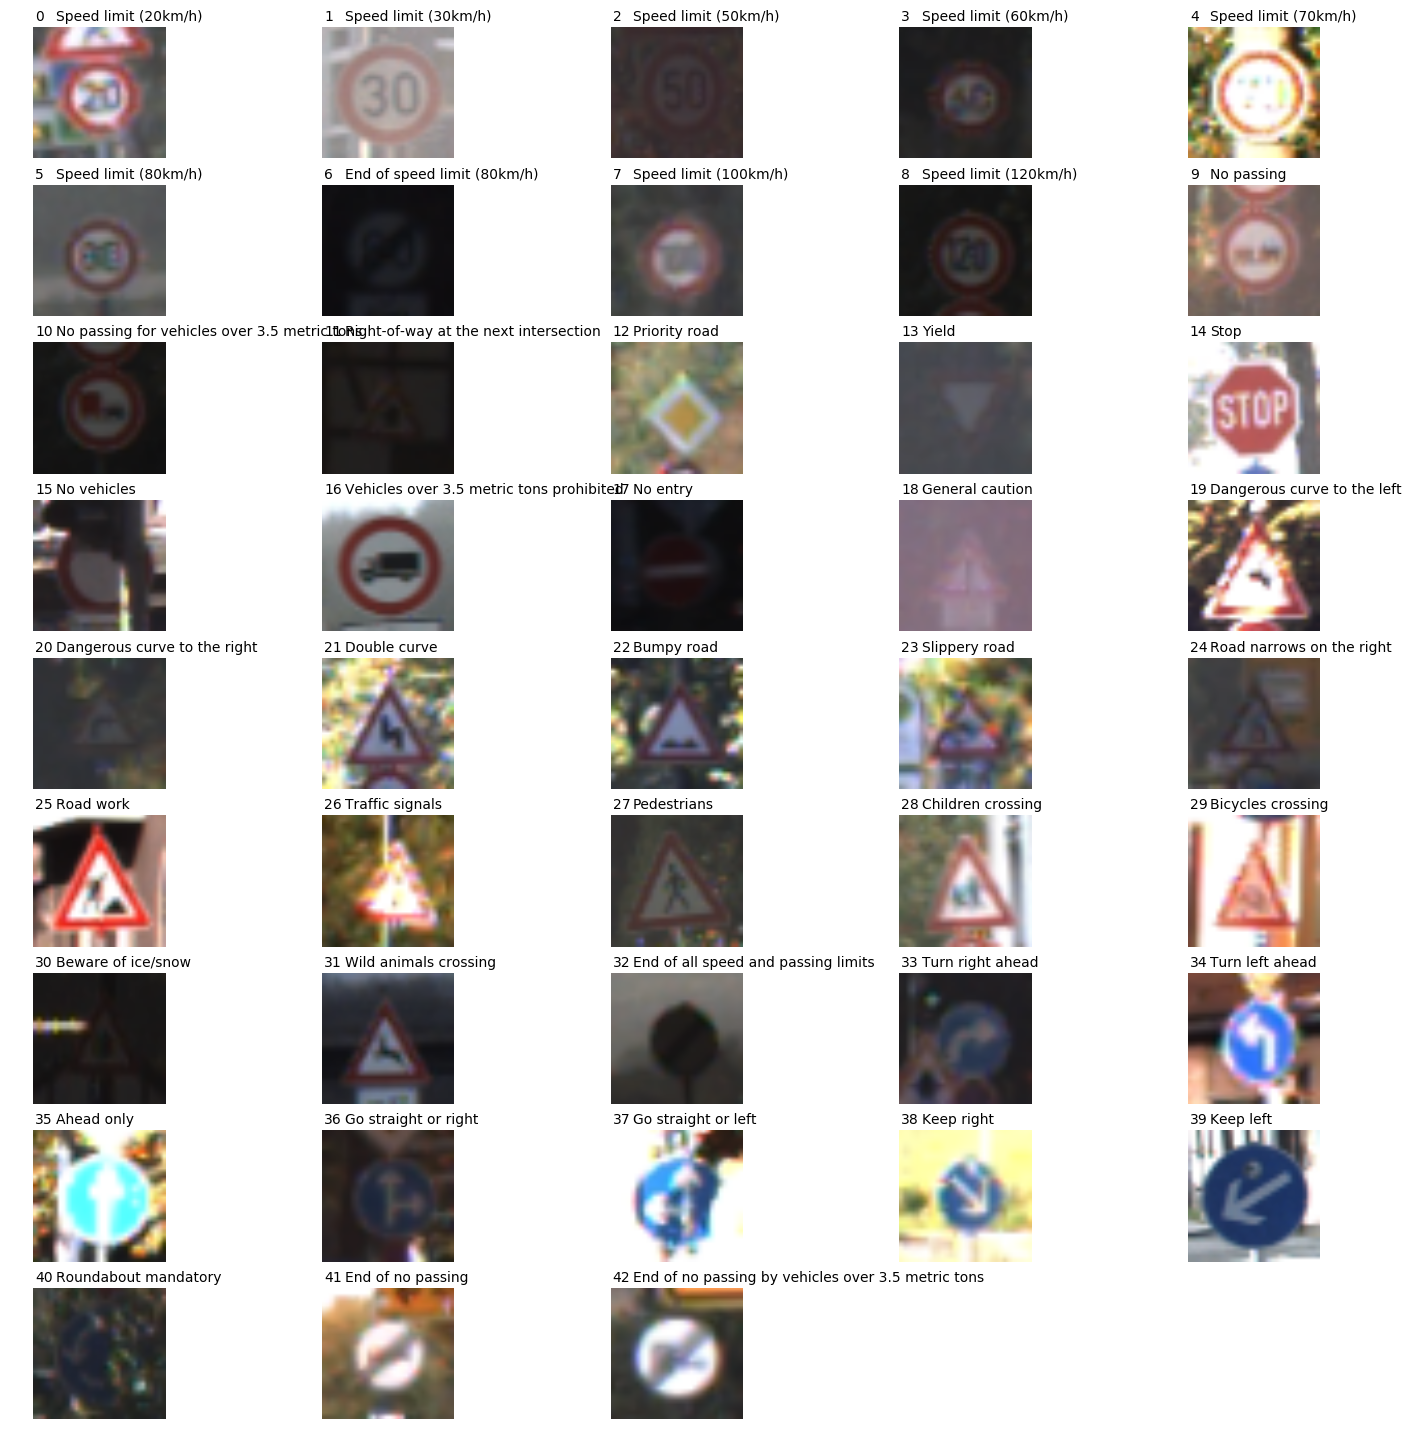

In [5]:
def plot_sample_images():
    gs = gridspec.GridSpec(10, 5)
    plt.figure(figsize=(18,20))
    i=0
    for index in uniq_indexes:
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = X_train[index]
        plt.subplot(10,5,i+1)
        label=str(y_train[index])
        plt.text(0, -2, label)
        plt.text(5, -2, labelNameDict[label])
        plt.imshow(img)
        plt.axis('off')
        i=i+1
    plt.show()

def plot_data_with_labels():
    plt.figure(figsize=(15,5))
    plt.bar(uniq_classes, uniq_class_counts)
    plt.xlabel('label')
    plt.xticks(uniq_classes)
    plt.ylabel('no. of samples')
    for a,b in zip(uniq_classes, uniq_class_counts): 
        plt.text(a, b+50, str(b))
    plt.show()
    
plot_data_with_labels()
print ('Sample Image for each label')
plot_sample_images()

### Image Preprocessing

Preprocessing includes normalization using opencv minmax normalization between 50 and 200. Final values reached after some tests. followed by median bluring because

1. Normalization will mitigate differences due to light condition across the data set and will make the pixel intesity consistant.

2. Bluring is done to remove noise/unwanted features. Median blur was chossen because it works good in removing salt and pepper noice and produced the best results when tested in comparison with averaging, gaussian blur or bilateralFilter.

Sample images before and after preprocessing plotted below


In [6]:
### Preprocess the data
def normalize_and_blur(img):
    img = cv2.normalize(img, img, 50, 200, cv2.NORM_MINMAX)
    cv2.medianBlur(img,3)
    return img

done


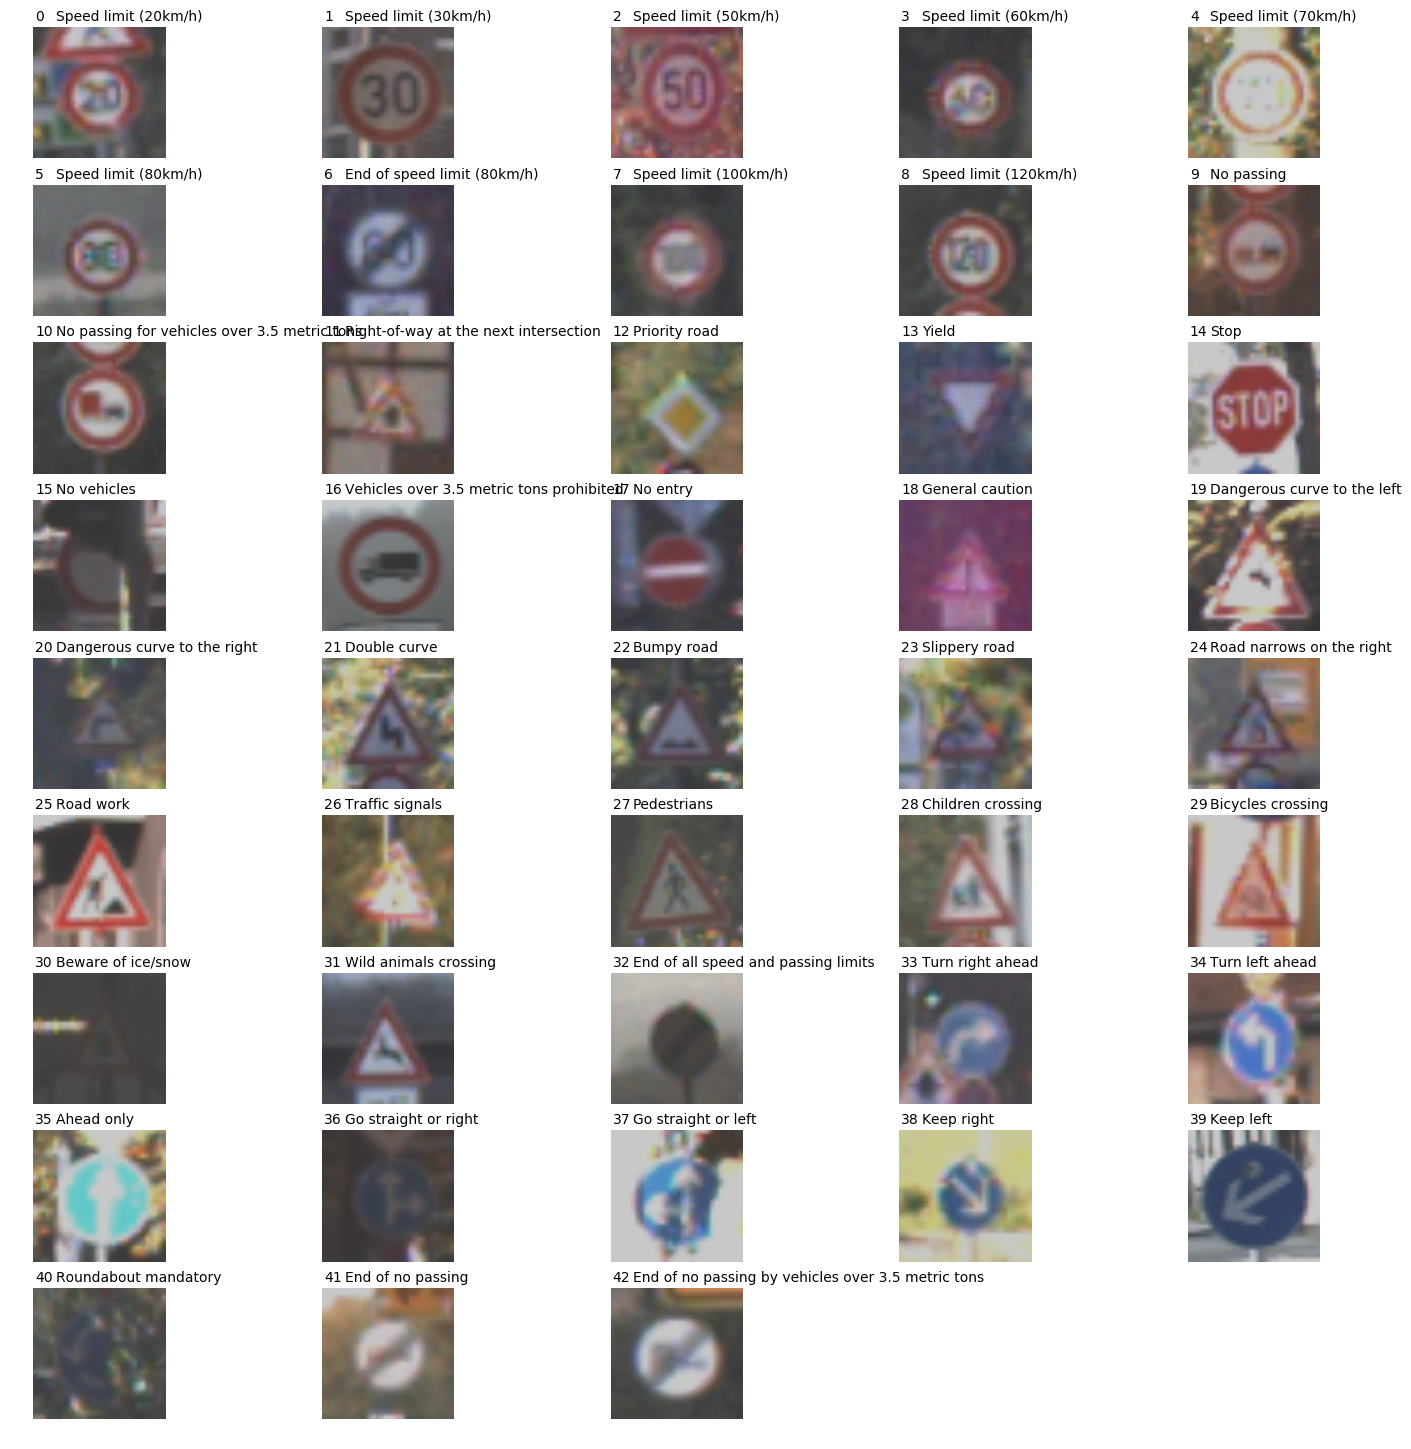

In [7]:
for i in range(len(X_train)):
    normalize_and_blur(X_train[i])

for i in range(len(X_train)):
    normalize_and_blur(X_train[i])

print("done")
plot_sample_images()

### Generate additional data

In [8]:
### Generate data additional data 
def transform_image(img,ang_range,shear_range,trans_range):
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    return img

# generate more data from images:
#new_images = []
#for cl,a,b in zip(uniq_classes, uniq_indexes, uniq_class_counts):
#    maxSamples = max(uniq_class_counts)
#    diff = maxSamples//b
#    k=b
#    for n in range(diff):
#        i = a
#        j = 0
#        while j < b:
#            img = transform_image(X_train[i],20,10,5)
#            new_images.append(img)
#            y_train = np.append(y_train, cl)
#            j = j+1
#            i = i+1
#            k = k+1
#            if  k >= maxSamples:
#               break
#        if  k >= maxSamples:
#                break
                
#X_train = np.concatenate((X_train, new_images), axis=0)
#uniq_classes, uniq_indexes, uniq_class_counts=np.unique(y_train, return_index=True, return_counts=True)
#plot_data_with_labels()

### Split data into train and validation sets

From the downloded data 76% is training data and 24% test data.

The training data is further split into training and validation data sets in a 70:30 ratio i.e. 70% of all training data is used for actual taining and 30% of it used for validation.

Training and validation data is setup using train_test_split from sklearn.

Used a test size of 0.3 because with 0.2 validation set had less then 8000 images and testing set had most. I think Validation accuracy will not be very accurate if the classifier had already seen most of the data. So this division seemed right.

random_state is set to zero so that the same set is not returned in successive runs. This seems more appropriate as the classifier needs to be trained on different images.

In [9]:
X_train, y_train = shuffle(X_train, y_train)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train , test_size=0.3, random_state=0)

print("Number of training examples =", len(X_train))
print("Number of validation examples =", len(X_validation))
print("Update image Shape: {}".format(X_train[0].shape))

Number of training examples = 27446
Number of validation examples = 11763
Update image Shape: (32, 32, 3)


### Define CNN architecture


Started with leNet and resources provided in the chapter and read about architectures like laNet, AlexNet, VGGNet GoogLeNet etc.

In comparison to others VGGNet like architecture appeard to be most suitable for image recognition without being too complex. Also, it was performing the best when tested on this task against laNet and AlexNet.

The final architecure is similar to VGGNet but not so deep with two conv-pool layers followed by two fully connected layers.

Two conv-pool layers are used because of small image size and because adding more layers with SAME padding(to not reduce the image size too quickly) had no sizable improvement in performance.

Testing showed that increasing depth/number of filter in a consistent manner with small steps in conv layers before a polling operation produced better results compared to bigger/suddend changes in conv layer. In fact the accuracy goes down if the depth is increased too rapidly.


Ref:
Feature Evaluation of Deep Convolutional Neural Networks for Object Recognition and Detection
Hirokatsu Kataoka, Kenji Iwata, Yutaka Satoh
https://arxiv.org/abs/1509.07627

In [14]:
def convNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    strides = 1
    filter_height  = 3
    filter_width = 3
    
    # Layer 1: Conv1. Input = 32x32x3. Output = 30x30x6.
    W = tf.Variable(tf.truncated_normal(shape=[filter_height, filter_width, 3, 6], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(6))
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.relu(x)
    # Layer 1: Conv2. Input = 30x30x6. Output = 28x28x9.
    W = tf.Variable(tf.truncated_normal(shape=[filter_height, filter_width, 6, 9], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(9))
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.relu(x)
    
    # Layer 1: Pooling. Input = 28x28x9. Output = 14x14x9.
    x = tf.nn.max_pool(x,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID')
    
    
    #Layer 2: Conv1. Input = 14x14x9. Output = 12x12x12.
    W = tf.Variable(tf.truncated_normal(shape=[filter_height, filter_width, 9, 12], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(12))
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.relu(x)
    #Layer 2: Conv2. Input = 12x12x12. Output = 10x10x16.
    W = tf.Variable(tf.truncated_normal(shape=[filter_height, filter_width, 12, 16], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(16))
    x = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.relu(x)
    
    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='VALID')
    
    
    # Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
      
    # Layer 3: Fully Connected. Input = 400. Output = 220.
    W =tf.Variable(tf.truncated_normal([400, 220], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(220))
    x = tf.add(tf.matmul(x, W), b)
    x = tf.nn.relu(x)
    # Layer 4: Fully Connected. Input = 84. Output = 43.
    W =tf.Variable(tf.truncated_normal([220, 43], mean = mu, stddev = sigma))
    b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(x, W), b)
    return logits


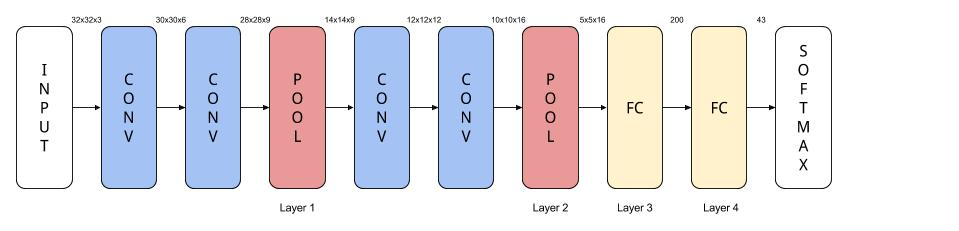

In [15]:
from IPython.display import Image
Image(filename="convnet_architecture.jpg")

### Train the model

<a href="http://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network">Good read about various paramter tuning</a>

1. started with the batch_size=1000 and epocs=10 with lerrning rate of 0.1. This gave very low initial accuracy so incremently reduced the learning rate and tested. Finally stopped at 0.001 as the best inital accuray achived by this.

2. With above it was observed that I got high initial accuracy which increased up to 6th or 7th interation and than started going down and finally finally went up on 10th. So started reducing the Batch size and increasing EPOCS.

3. Reached the final values above after some trial and error. Final EPOCS value was taken after the accuracy flattened for around 5-10 iterations and there was't any considerable improvements with more.

3. The training data is shuffled after every iteration to avoid overfitting.

4. Adam Optimizer was used after reading <a href="http://sebastianruder.com/optimizing-gradient-descent/">ref</a> and because it produced best results after testing in comparison with other optimizers in tenserflow.

Ref:

From Nitish Shirish Keskar, Dheevatsa Mudigere, Jorge Nocedal, Mikhail Smelyanskiy, Ping Tak Peter Tang. On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima.
https://arxiv.org/abs/1609.04836

Yoshua Bengio. Practical recommendations for gradient-based training of deep architectures
https://arxiv.org/abs/1206.5533


In [16]:
### Train your model

EPOCHS = 40
BATCH_SIZE = 400
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = convNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0,0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss *  len(batch_x))
    return total_accuracy/num_examples, total_loss/num_examples


Training...
EPOCH 1 ...
Validation loss = 1.316
Validation Accuracy = 0.628
EPOCH 2 ...
Validation loss = 0.405
Validation Accuracy = 0.886
EPOCH 3 ...
Validation loss = 0.291
Validation Accuracy = 0.916
EPOCH 4 ...
Validation loss = 0.213
Validation Accuracy = 0.941
EPOCH 5 ...
Validation loss = 0.166
Validation Accuracy = 0.955
EPOCH 6 ...
Validation loss = 0.166
Validation Accuracy = 0.955
EPOCH 7 ...
Validation loss = 0.149
Validation Accuracy = 0.959
EPOCH 8 ...
Validation loss = 0.127
Validation Accuracy = 0.967
EPOCH 9 ...
Validation loss = 0.132
Validation Accuracy = 0.966
EPOCH 10 ...
Validation loss = 0.140
Validation Accuracy = 0.964
EPOCH 11 ...
Validation loss = 0.125
Validation Accuracy = 0.968
EPOCH 12 ...
Validation loss = 0.117
Validation Accuracy = 0.973
EPOCH 13 ...
Validation loss = 0.117
Validation Accuracy = 0.973
EPOCH 14 ...
Validation loss = 0.113
Validation Accuracy = 0.973
EPOCH 15 ...
Validation loss = 0.113
Validation Accuracy = 0.977
EPOCH 16 ...
Validatio

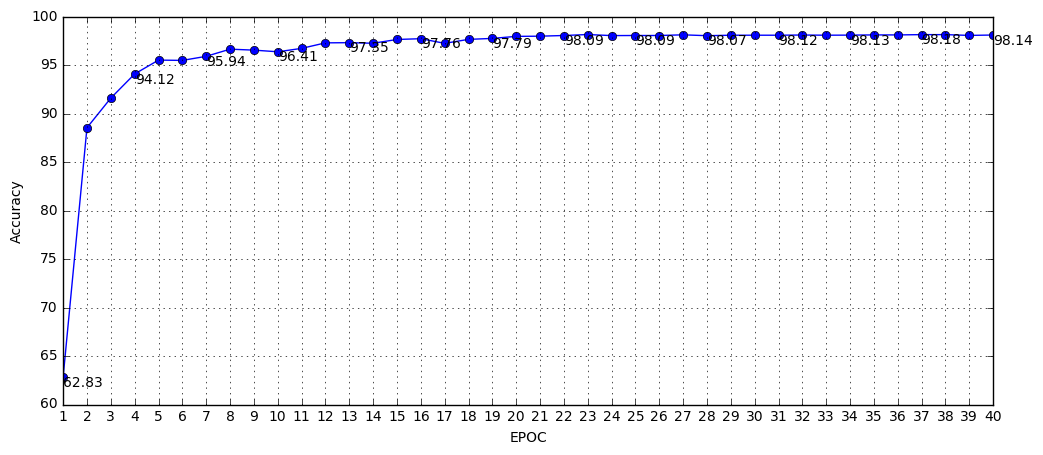

In [17]:
accuracy_map = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, validation_loss = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {:.3f}".format(validation_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        accuracy_map.append(round(validation_accuracy*100,2))
    plt.figure(figsize=(12,5))
    plt.xticks(range(1, EPOCHS+1))
    plt.xlabel('EPOC')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(range(1,EPOCHS+1), accuracy_map,'-o')
    for a,b in list(zip(range(1,EPOCHS+1), accuracy_map))[0::3]:
        plt.text(a, b-1, str(b))
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'model')
    print("Model saved")

In [18]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    tf.trainable_variables()
    test_accuracy,test_loss = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.906


### Test a Model on New Images

Used several pictures of traffic signs found on the web not seen by the classifier.

In [19]:
### Load new images.
def plot_images(images, x, y,labels):
    gs = gridspec.GridSpec(x, y)
    i=0
    for index in range(len(images)):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        img = images[index]
        plt.subplot(x,y,i+1)
        label=str(labels[index])
        plt.text(0, -2, label)
        plt.imshow(img)
        plt.axis('off')
        i=i+1
    plt.show()

for i in range(1,17):
    image = cv2.imread('test'+str(i)+'.jpg',cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(32, 32), interpolation = cv2.INTER_AREA)
    cv2.imwrite('test_sampled'+str(i)+'.jpg',image)

In [20]:
new_images=[]
new_labels=['14','31','12','16','1','25','32','32','8','18','0','40','13','1','29','18']

for i in range(1,17):
    img = mpimg.imread('test_sampled'+str(i)+'.jpg')
    img = normalize_and_blur(img)
    new_images.append(img)

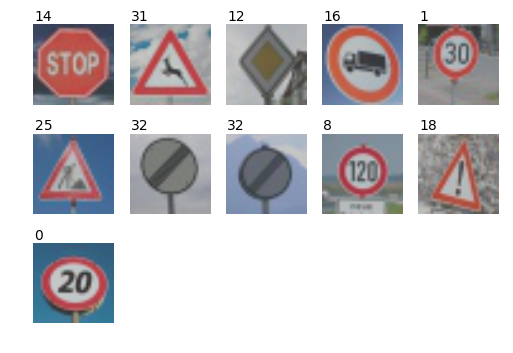

Actual labels    : [14 31 12 16 1 25 32 32 8 18 0]
predicted labels : [14 31 12 16 13 25  9 32  8 18  0]


In [21]:
#new_images[:11]
#new_labels[:11]
plot_images(new_images[:11], 3, 5,new_labels[:11])

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #tf.trainable_variables()
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: new_images[:11]})
    print ("Actual labels    : " + '['+' '.join(new_labels[:11])+']')
    print ("predicted labels : " + str(predictions))

### Run the predictions.

I have chossen these images becuse they have multiple signs some of them seen in training set other not. This will be interesting to see what the model gives priority to.

While one image is similar but have diffent color. As the model is trained on color images this will show if the model can extend to different colors.

Selected candidate images are plotted below

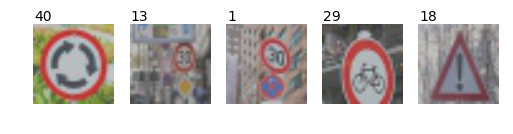

Actual labels    : [40 13 1 29 18]
predicted labels : [15 17 17 24 18]


In [22]:
#new_images[11:16]
#new_labels[11:16]
plot_images(new_images[11:16], 1, 5,new_labels[11:16])

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #tf.trainable_variables()
    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: new_images[11:16]})
    print ("Actual labels    : " + '['+' '.join(new_labels[11:16])+']')
    print ("predicted labels : " + str(predictions))

### Visualize the softmax probabilities.

In [23]:

soft_max = None
with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    soft_max = sess.run(tf.nn.softmax(logits), {x:new_images[11:16]})
    print ('Done')

Done


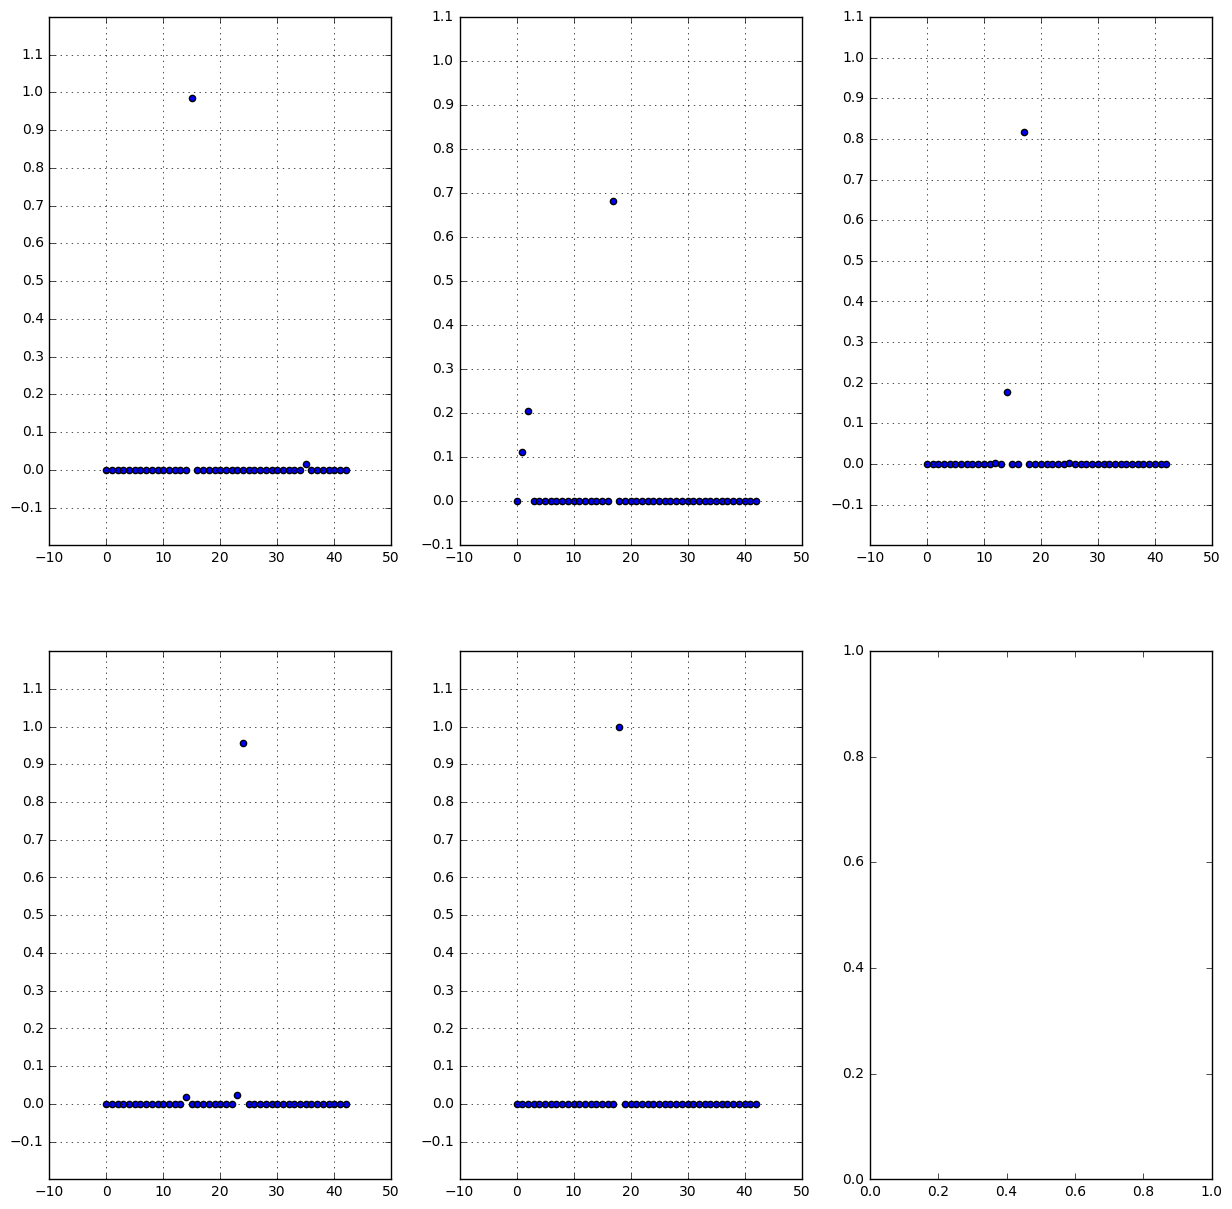

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(15,15))
ax1, ax2, ax3, ax4, ax5, ax6= axes.ravel()
ax1.scatter(np.arange(0,43), soft_max[0])
ax1.grid(True)
ax1.set_yticks(np.arange(-0.1,1.1,0.1))
ax2.scatter(np.arange(0,43), soft_max[1])
ax2.grid(True)
ax2.set_yticks(np.arange(-0.1,1.1,0.1))
ax3.scatter(np.arange(0,43), soft_max[2])
ax3.grid(True)
ax3.set_yticks(np.arange(-0.1,1.1,0.1))
ax4.scatter(np.arange(0,43), soft_max[3])
ax4.grid(True)
ax4.set_yticks(np.arange(-0.1,1.1,0.1))
ax5.scatter(np.arange(0,43), soft_max[4])
ax5.grid(True)
ax5.set_yticks(np.arange(-0.1,1.1,0.1))

### Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k)

In [25]:
indices = None
with tf.Session() as sess: 
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    values,indices = sess.run(tf.nn.top_k(soft_max, k=5))
    print (values)
    print (indices)

[[  9.84194875e-01   1.58050787e-02   1.88096649e-10   8.60643778e-11
    6.51628317e-12]
 [  6.80951059e-01   2.05243751e-01   1.12578571e-01   9.65529995e-04
    1.57428192e-04]
 [  8.15771043e-01   1.78345591e-01   2.86064204e-03   2.47103022e-03
    3.98832228e-04]
 [  9.56751406e-01   2.29176339e-02   1.97519958e-02   4.97369852e-04
    4.95247223e-05]
 [  1.00000000e+00   9.64763859e-13   1.79323037e-15   4.55297282e-17
    1.30376367e-22]]
[[15 35 38 22 20]
 [17  2  1  8 13]
 [17 14 25 12 11]
 [24 23 14 29 17]
 [18 26 27 24 11]]


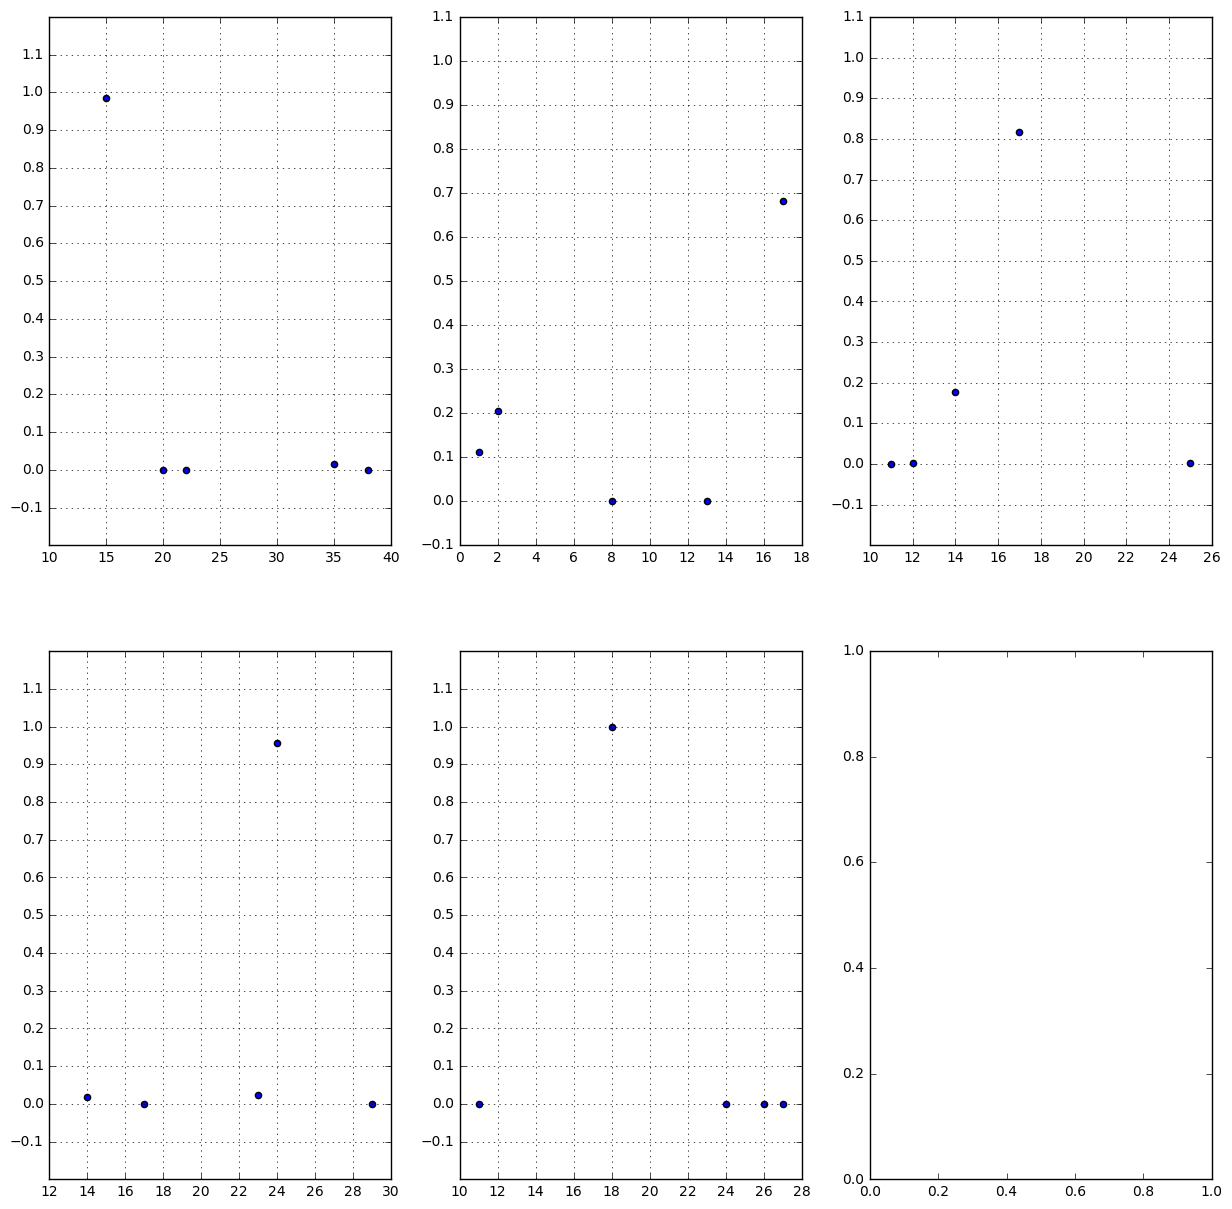

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(15,15))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.ravel()

ax1.scatter(indices[0], values[0])
ax1.grid(True)
ax1.set_yticks(np.arange(-0.1,1.1,0.1))
ax2.scatter(indices[1], values[1])
ax2.grid(True)
ax2.set_yticks(np.arange(-0.1,1.1,0.1))
ax3.scatter(indices[2], values[2])
ax3.grid(True)
ax3.set_yticks(np.arange(-0.1,1.1,0.1))
ax4.scatter(indices[3], values[3])
ax4.grid(True)
ax4.set_yticks(np.arange(-0.1,1.1,0.1))
ax5.scatter(indices[4], values[4])
ax5.grid(True)
ax5.set_yticks(np.arange(-0.1,1.1,0.1))